In [1]:
import xarray as xr 
import dask as da
import os
import matplotlib.pyplot as plt
import numpy as np

## Constants

In [2]:
t_s = -1.0
t_r = 3.0

A_max = 20.0
t_a = -10.0
A_0 = 0.2
a = 0.2
b = 0.1

## Datos

In [3]:
ds_pr = xr.open_dataset('CR2MET_pr_v2.0_day_1979_2020_005deg.nc')
ds_t2m = xr.open_dataset('CR2MET_t2m_v2.0_day_1979_2020_005deg.nc')

## Temperature

In [5]:
ds_t2m

<xarray.Dataset>
Dimensions:  (lat: 800, lon: 220, time: 15096)
Coordinates:
  * lat      (lat) float32 -56.97 -56.92 -56.88 -56.83 ... -17.12 -17.08 -17.02
  * lon      (lon) float32 -76.97 -76.93 -76.88 -76.82 ... -66.12 -66.07 -66.03
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-04-30
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes: (12/20)
    creation_date:       21-Sep-2020 19:15:10
    ls_vars_s2:          tmin tmina tmax tmaxa t2m t2ma t850 t850a t700 td2m ...
    nb_months:           -1  0  1
    av_ens_qtl:          0.0
    agg_metr:            median
    authors:             Boisier et al.
    ...                  ...
    par_nd_stn_min:      10
    par_nd_stn_spl:      50
    par_dlat_min:        2
    par_dlat_max:        15
    history:             Wed Jan 22 12:11:25 2020: ncks -v tmin /home/nvaldeb...
    NCO:                 netCDF Operators version 4.7.9 (Homepage = httpwrite...

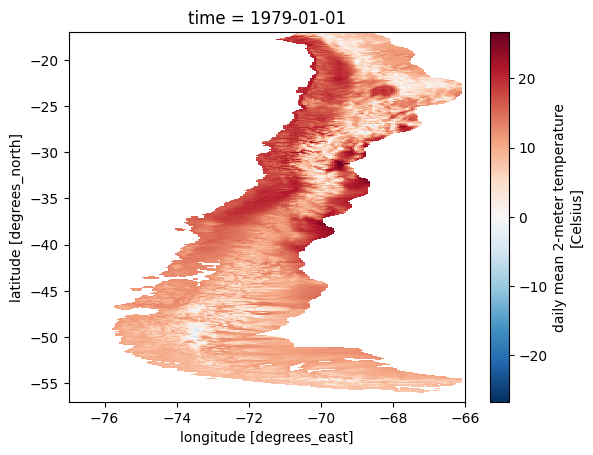

In [116]:
ds_t2m['t2m'][:1,:,:].plot()

In [105]:
# Selecciona los datos para la primera coordenada temporal
temp = ds_t2m['t2m'][0:1,:,:]

# Elimina los valores NaN
temp_sn = xr.where(np.isnan(temp), 0, temp)

#Valores de temperatura
temp_sn.values.size

176000

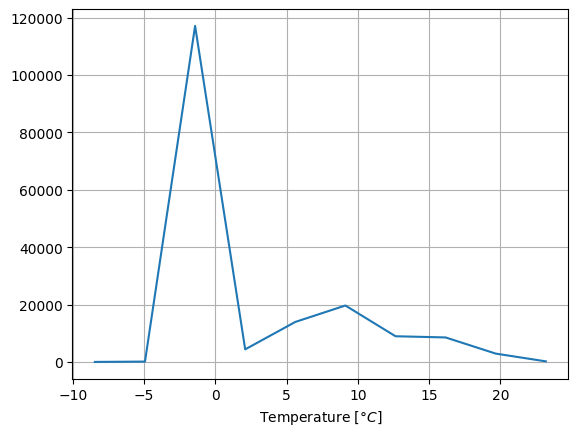

In [50]:
# Crea un histograma
h = np.histogram(temp_sn)

# Obtén los valores del histograma
values = h[0]

# Visualiza el histograma
plt.plot(h[1][:-1], values)
plt.xlabel('Temperature [$\degree C$]')
plt.grid()
plt.show()

## Precipitation

In [9]:
ds_pr

<xarray.Dataset>
Dimensions:  (lat: 800, lon: 220, time: 15096)
Coordinates:
  * lat      (lat) float32 -56.97 -56.92 -56.88 -56.83 ... -17.12 -17.08 -17.02
  * lon      (lon) float32 -76.97 -76.93 -76.88 -76.82 ... -66.12 -66.07 -66.03
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-04-30
Data variables:
    pr       (time, lat, lon) float32 ...
    pr_sd    (time, lat, lon) float32 ...
Attributes: (12/23)
    creation_date:        21-Sep-2020 18:52:02
    authors:              Boisier et al.
    topo_res:             005 025 05
    ls_vars:              pr logpr prc iqu iqv tcw w700 dpr slpa z300a
    obs_file:             CR2stn_QC_pr_day_1979_2018
    par_ens_size:         30
    ...                   ...
    par_use_logit:        1
    par_dlat_min:         3
    par_pday_min:         0.5
    ens_agg_metric:       quantile
    ens_qtl_value:        0.5
    ens_force_dry:        0

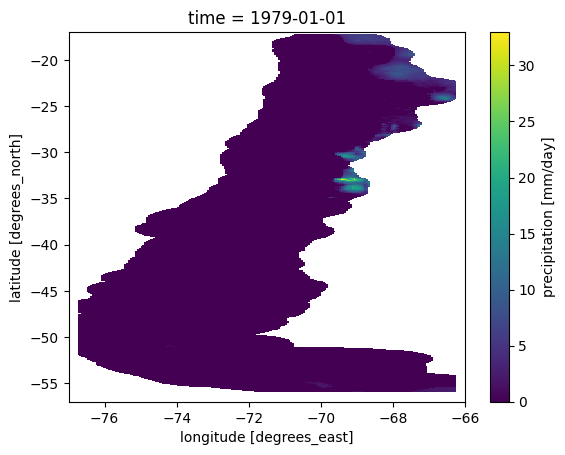

In [56]:
ds_pr['pr'][:1,:,:].plot()

In [118]:
# Selecciona los datos para la primera coordenada temporal
pres = ds_pr['pr'][:,:,:]

# Elimina los valores NaN
pres_sn = xr.where(np.isnan(pres), 0, pres)

#Valores de temperatura
pres_sn.values.size

2569600000

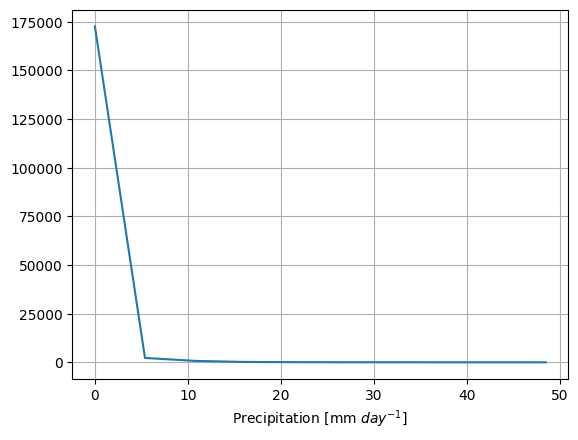

In [51]:
# Crea un histograma
p = np.histogram(pres_sn)

# Obtén los valores del histograma
val = p[0]

# Visualiza el histograma
plt.plot(p[1][:-1], val)
plt.xlabel('Precipitation [mm $day^{-1}$]')
plt.grid()
plt.show()

## Aspectos importantes

#### Funciones

In [34]:
temp_sn_column = temp_sn.values.reshape(-1, 1)
temp_sn_column[176000-1]

k = np.zeros_like(temp_sn, dtype='uint8').reshape(-1, 1)
k[176000-1]

ola = range(temp_sn.size - 1)

temp_sn.values[temp_sn.values > tr].size

mask = (ts <= temp_sn) & (temp_sn <= tr)
np.unique(temp_sn.values[mask])

array([-0.99833333, -0.99666667, -0.985     , ...,  2.9933333 ,
        2.9966667 ,  3.        ], dtype=float32)

In [59]:
def K_sf(temp_sn):

    # Condiciones
    ts = -1.0
    tr = 3.0

    #Pasamos a vector columna
    temp_sn_column = temp_sn.reshape(-1, 1)

    # Inicializar la matriz k con ceros
    k = np.zeros_like(temp_sn, dtype='float16').reshape(-1, 1)
    
    # Aplicar condiciones elemento por elemento
    for i in range(temp_sn.size - 1):
        
        if temp_sn_column[i] <= ts:
            k[i] = 1.0

        elif ts <= temp_sn_column[i] <= tr:
            k[i] = (tr - temp_sn_column[i]) / (tr - ts)

        elif temp_sn_column[i] > tr:
            k[i] = 0.0

    return k.reshape(-1)

In [30]:
def K_sf1(temp_sn):
    
    # Condiciones
    ts = -1.0
    tr = 3.0

    # Inicializar la matriz k con ceros
    k = np.zeros_like(temp_sn, dtype='float16')
    
    # Aplicar la función a cada valor de temp_sn
    k[temp_sn <= ts] = 1.0
    mask = (ts <= temp_sn) & (temp_sn <= tr)
    k[mask] = (tr - temp_sn[mask]) / (tr - ts)
    k[temp_sn > tr] = 0.0

    return k

In [31]:
def K_sf1_parallel(temp_sn):

    # Convertir la matriz a un arreglo de NumPy.
    temp_sn = np.asarray(temp_sn)

    # Definir las condiciones como constantes de NumPy.
    ts = -1.0
    tr = 3.0

    # Crear una máscara de NumPy.
    mask = (temp_sn >= ts) & (temp_sn <= tr)

    # Definir la función a paralelizar.
    def apply_function(x):
        if x <= ts:
            return 1.0
        elif mask:
            return (tr - x) / (tr - ts)
        elif x > tr:
            return 0.0

    # Paralelizar la función.
    k = np.vectorize(apply_function)(temp_sn)

    return k

In [32]:
def A_asterisco(temp_sn):

    #Condiciones
    ta = -10.0
    A_0 = 0.2
    a = 0.2
    b = 0.1

# Inicializar la matriz k con ceros
    A_ast = np.zeros_like(temp_sn, dtype='float16')
    
    # Aplicar la función a cada valor de temp_sn
    A_ast[temp_sn <= ta] = 0.0
    mask = (ta <= temp_sn) & (temp_sn <= 0)
    A_ast[mask] = A_0*(ta - temp_sn[mask]) / (ta)
    mask2 = (temp_sn > 0)
    A_ast[mask2] =   a*(temp_sn[mask2]**2) + (b*temp_sn[mask2]) + A_0

    return A_ast

#### Funcion para Snowfall

In [33]:
def S(pres_sn, K):

    S_ = K * pres_sn 

    return S_

#### Funcion para Ablation 

In [34]:
def A(temp_sn):

    #Constants 
    A_max = 20.0
    A_ = A_asterisco(temp_sn)

    return np.minimum(A_max, A_)


#### Funcion para SWE 

In [66]:
def delta_SWE(S, A):

    SWE_inicial = 0.0
    SWE = SWE_inicial + S - A
    return SWE

#### Funcion para particionar variables

In [3]:
def parti(i,j,T=False, P=False):
    if T:
        
        T = ds_t2m['t2m'][i:j,:,:]

        # Elimina los valores NaN
        #t_sn_part = xr.where(np.isnan(T), 0, T)
        
        return T.values
    
    if P:
        
        p = ds_pr['pr'][i:j,:,:]

        # Elimina los valores NaN
        #p_sn = xr.where(np.isnan(p), 0, p)

        return p.values

In [3]:
import dask.delayed as delayed

def parti_dask_delayed(i, j, T=False, P=False):
    if T:
        # Selecciona los datos para la primera coordenada temporal
        T = delayed(ds_t2m['t2m'][i:j, :, :]).compute()

        # Elimina los valores NaN
        t_sn_part = delayed(np.where(np.isnan(T), 0, T)).compute()

        # Valores de temperatura
        return t_sn_part
    if P:
        # Selecciona los datos para la primera coordenada temporal
        p = delayed(ds_pr['pr'][i:j, :, :]).compute()

        # Elimina los valores NaN
        p_sn = delayed(np.where(np.isnan(p), 0, p)).compute()

        # Valores de precipitación
        return p_sn

In [5]:
import dask.array as da

def parti_dask(i, j, T=False, P=False):
    if T:
        # Selecciona los datos para la primera coordenada temporal
        T = da.from_array(ds_t2m['t2m'][i:j, :, :], chunks=(1000, 800, 200))

        # Elimina los valores NaN
        t_sn_part = da.where(np.isnan(T), 0, T)

        # Valores de temperatura
        return t_sn_part.compute()
    if P:
        # Selecciona los datos para la primera coordenada temporal
        p = da.from_array(ds_pr['pr'][i:j, :, :], chunks=(1000, 800, 200))

        # Elimina los valores NaN
        p_sn = da.where(np.isnan(p), 0, p)

        # Valores de precipitación
        return p_sn.compute()

#### Funcion unica

In [6]:
def modelo_completo(temp_sn, pres_sn):

    S_ = S(pres_sn, K_sf1(temp_sn))
    A_ = A(temp_sn)

    prev_SWE = np.zeros(S_.shape, dtype='float16')
    SWE = np.zeros(S_.shape, dtype='float16')  # Initialize SWE with zeros of the same shape as S_
    
    for i in range(0, 3):
        for j in range(1, 4):
            if j > i:
        
                SWE[i:j,:,:] = prev_SWE[i:j, :, :] + (S_[i:j,:,:] - A_[i:j,:,:])  
                prev_SWE[i:j, :, :] = SWE[i:j, :, :]  # Update prev_SWE for the next iteration

    return SWE, S_, A_

In [197]:
def modelo_completo2(temp_sn, pres_sn):

    S_ = S(pres_sn, K_sf1(temp_sn))
    A_ = A(temp_sn)

    prev_SWE = np.zeros(S_.shape, dtype='float16')
    SWE = np.zeros(S_.shape, dtype='float16')  # Initialize SWE with zeros of the same shape as S_
    
    for i in range(1, 3):
        
        SWE[:i,:,:] = prev_SWE[:i, :, :] + (S_[:i,:,:] - A_[:i,:,:])  
        prev_SWE[:i, :, :] = SWE[:i, :, :]  # Update prev_SWE for the next iteration

    return SWE, S_, A_

In [209]:
def modelo_completo3(temp_sn, pres_sn):

    S_ = S(pres_sn, K_sf1(temp_sn))
    A_ = A(temp_sn)

    SWE = np.zeros(S_.shape, dtype='float16')  # Initialize SWE with zeros of the same shape as S_

    for i in range(0, 1):
        for j in range(1, 2):
            if j > i:
        
                SWE[i:j,:,:] = SWE[i-1:j-1, :, :] + (S_[i:j,:,:] - A_[i:j,:,:])  
                

    return SWE, S_, A_

In [35]:
def modelo_completo4(temp_sn, pres_sn):

    S_ = S(pres_sn, K_sf1(temp_sn))
    A_ = A(temp_sn)

    prev_SWE = np.zeros(S_.shape, dtype='float16')
    SWE = np.zeros(S_.shape, dtype='float16')  # Initialize SWE with zeros of the same shape as S_
    
    for i in range(S_.shape[0]):
        if i == 0:
            SWE[i, :, :] = 0.0
        else:
            SWE[i, :, :] = SWE[i-1, :, :] + (S_[i, :, :] - A_[i, :, :])

    return SWE, S_, A_

In [4]:
def modelo_completo_final(temp_sn, pres_sn, t_s, t_r, t_a, A_0, a, b, A_max):

    #temp_sn = temp_sn.chunk(500000)
    #pres_sn = pres_sn.chunk(500000)

    # KSF 

    k = np.zeros_like(temp_sn, dtype='float16')
    k[temp_sn <= t_s] = 1.0
    mask = (t_s <= temp_sn) & (temp_sn <= t_r)
    k[mask] = (t_r - temp_sn[mask]) / (t_r - t_s)
    k[temp_sn > t_r] = 0.0

    # A_*

    A_ast = np.zeros_like(temp_sn, dtype='float16')
    A_ast[temp_sn <= t_a] = 0.0
    mask = (t_a <= temp_sn) & (temp_sn <= 0)
    A_ast[mask] = A_0*(t_a - temp_sn[mask]) / (t_a)
    mask2 = (temp_sn > 0)
    A_ast[mask2] =   a*(temp_sn[mask2]**2) + (b*temp_sn[mask2]) + A_0

    # SNOWFALL

    S_ = k * pres_sn 

    # ABLATION 

    A_ = np.zeros(S_.shape, dtype='float16')

    # DELTA SWE

    SWE = np.zeros(S_.shape, dtype='float16')  # Initialize SWE with zeros of the same shape as S_
    
    for i in range(S_.shape[0]):
        if i == 0:
            A_[i, :, :] = np.minimum(np.minimum(A_max, A_ast[i, :, :]), S_[i, :, :])
            SWE[i, :, :] = S_[i, :, :] - A_[i, :, :]
        else:
            A_[i, :, :] = np.minimum(np.minimum(A_max, A_ast[i, :, :]), S_[i, :, :])
            SWE[i, :, :] = SWE[i-1, :, :] + (S_[i, :, :] - A_[i, :, :])

    return SWE, S_, A_

#### Ejemplo de uso

##### De funciones

In [78]:
result = K_sf(temp_sn.values)

# Imprimir el resultado
print(result)

[0.75 0.75 0.75 ... 0.75 0.75 0.  ]


In [47]:
result1 = K_sf1(temp_sn.values)

# Imprimir el resultado
print(result1)

[[[0.75 0.75 0.75 ... 0.75 0.75 0.75]
  [0.75 0.75 0.75 ... 0.75 0.75 0.75]
  [0.75 0.75 0.75 ... 0.75 0.75 0.75]
  ...
  [0.75 0.75 0.75 ... 0.75 0.75 0.75]
  [0.75 0.75 0.75 ... 0.75 0.75 0.75]
  [0.75 0.75 0.75 ... 0.75 0.75 0.75]]]


In [48]:
result_S = S(pres_sn.values, result1)

# Imprimir el resultado
print(result_S)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [123]:
temp_part1 = parti(0,15731)

#result_part = K_sf1(temp_part1)

In [124]:
temp_part1.size #total de datos

2656896000

In [63]:
temp_part = parti(0,365, T=True)
presi_part = parti(0,365, P=True)
result_A_asterisco = A_asterisco(temp_part)
print(result_A_asterisco)

#print(temp_part*temp_part)

[[[0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  ...
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]]

 [[0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  ...
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]]

 [[0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  ...
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]]

 ...

 [[0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  ...
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]]

 [[0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  ...
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0.2]
  [0.2 0.2 0.2 ... 0.2 0.2 0

##### Comprobacion

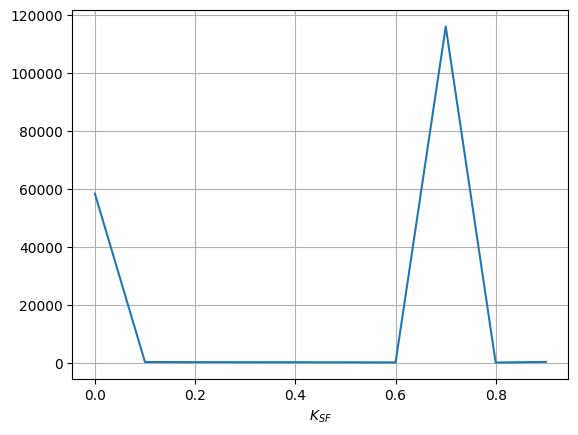

In [79]:
# Crea un histograma
r = np.histogram(result)

# Obtén los valores del histograma
va = r[0]

# Visualiza el histograma
plt.plot(r[1][:-1], va)
plt.xlabel('$K_{SF}$')
plt.grid()
plt.show()

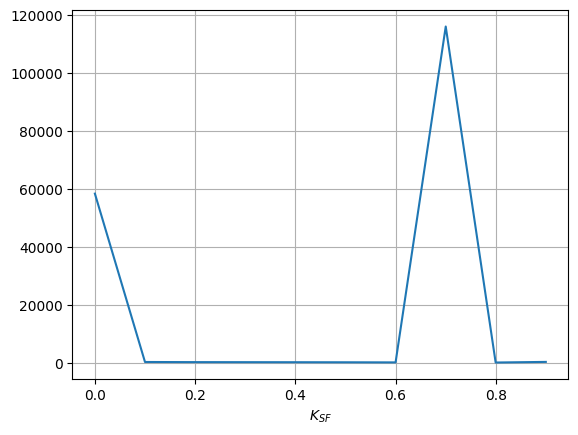

In [53]:
# Crea un histograma
r1 = np.histogram(result1)

# Obtén los valores del histograma
va1 = r1[0]

# Visualiza el histograma
plt.plot(r1[1][:-1], va1)
plt.xlabel('$K_{SF}$')
plt.grid()
plt.show()

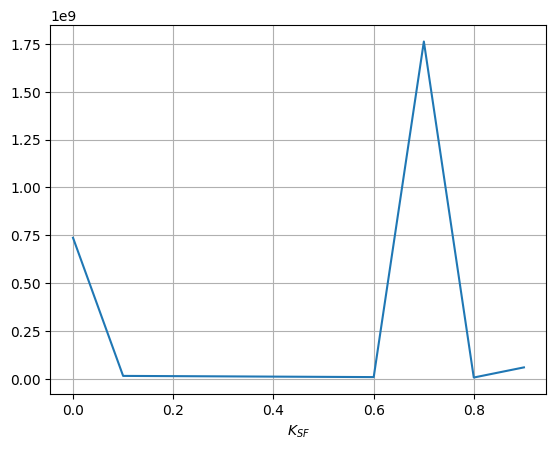

In [95]:
# Crea un histograma
r_p = np.histogram(result_part)

# Obtén los valores del histograma
va_p = r_p[0]

# Visualiza el histograma
plt.plot(r_p[1][:-1], va_p)
plt.xlabel('$K_{SF}$')
plt.grid()
plt.show()

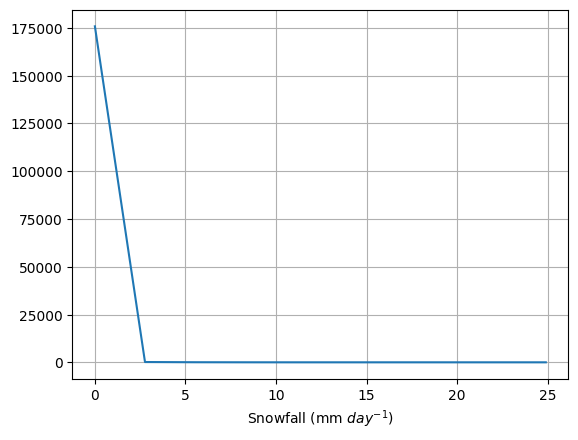

In [54]:
# Crea un histograma
r_S = np.histogram(result_S)

# Obtén los valores del histograma
va_S = r_S[0]

# Visualiza el histograma
plt.plot(r_S[1][:-1], va_S)
plt.xlabel('Snowfall (mm $day^{-1}$)')
plt.grid()
plt.show()

--------------------------------------------------------------------------

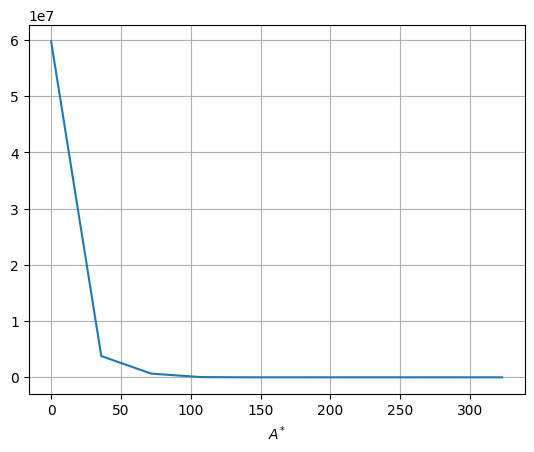

In [64]:
# Crea un histograma
r_ast = np.histogram(result_A_asterisco)

# Obtén los valores del histograma
va_ast = r_ast[0]

# Visualiza el histograma
plt.plot(r_ast[1][:-1], va_ast)
plt.xlabel('$A^{*}$')
plt.grid()
plt.show()

##### Confirmacion

In [80]:
print("----- Condicion 1 -----")
print(temp_sn.values[temp_sn.values <= ts].size)
count_condition_1 = np.count_nonzero(result == 1.0)
print(count_condition_1)
print("-----------------------")

print("----- Condicion 2 -----")
mask = (ts <= temp_sn.values) & (temp_sn.values <= tr)
print(((tr - temp_sn.values[mask]) / (tr - ts)).size)
# Contar elementos según la condición con ((tr - temp_sn.values[mask]) / (tr - ts))
count_condition_2 = np.count_nonzero(mask)
print(count_condition_2)
print("-----------------------")

print("----- Condicion 3 -----")
print(temp_sn.values[temp_sn.values > tr].size)
count_condition_3 = np.count_nonzero(result == 0.0)
print(count_condition_3)
print("-----------------------")


print("-------- Total --------")
print(temp_sn.values.size)
print(count_condition_1 + count_condition_2 + count_condition_3)

----- Condicion 1 -----
222
222
-----------------------
----- Condicion 2 -----
117720
117720
-----------------------
----- Condicion 3 -----
58058
58061
-----------------------
-------- Total --------
176000
176003


In [44]:
print("----- Condicion 1 -----")
print(temp_sn.values[temp_sn.values <= ts].size)
count_condition_1 = np.count_nonzero(result1 == 1.0)
print(count_condition_1)
print("-----------------------")

print("----- Condicion 2 -----")
mask = (ts <= temp_sn.values) & (temp_sn.values <= tr)
print(((tr - temp_sn.values[mask]) / (tr - ts)).size)
# Contar elementos según la condición con ((tr - temp_sn.values[mask]) / (tr - ts))
count_condition_2 = np.count_nonzero(mask)
print(count_condition_2)
print("-----------------------")

print("----- Condicion 3 -----")
print(temp_sn.values[temp_sn.values > tr].size)
count_condition_3 = np.count_nonzero(result1 == 0.0)
print(count_condition_3)
print("-----------------------")


print("-------- Total --------")
print(temp_sn.values.size)
print(count_condition_1 + count_condition_2 + count_condition_3)

----- Condicion 1 -----
222
222
-----------------------
----- Condicion 2 -----
117720
117720
-----------------------
----- Condicion 3 -----
58058
58060
-----------------------
-------- Total --------
176000
176002


In [86]:
# Medir tiempo de ejecución para K_sf1
%timeit -r 492 -n 100 K_sf1(temp_sn.values) #-----------------------> Mejor metodo

# Medir tiempo de ejecución para K_sf
#%timeit -r 10 -n 10 K_sf(temp_sn.values) #------------------------> indeterminado pero <5 min

727 µs ± 6.14 µs per loop (mean ± std. dev. of 492 runs, 100 loops each)


## Modelo I
Queremos resolver: 

$S = P  K_{SF} $  

Donde $ K_{SF} $: 


$ K_{SF} =
\begin{cases}
    1, & \text{if } T \leq T_{\text{s}} \\
    \frac{T_{r} - T}{T_{r} -T_{s}}, & \text{if } T_{s} \leq T \leq T_{r}  \\
    0, & \text{if } T_{r} < T
\end{cases}$

### Aplicando S para calcular snowfall en todas las series de tiempo

In [7]:
# Selecciona los datos para la primera coordenada temporal
T = ds_t2m['t2m'][:,:,:]

# Elimina los valores NaN
t_sn = xr.where(np.isnan(T), 0, T)

#Valores de temperatura
t_sn.values.size

2656896000

In [6]:
# Selecciona los datos para la primera coordenada temporal
p = ds_pr['pr'][:,:,:]

# Elimina los valores NaN
p_sn = xr.where(np.isnan(p), 0, p)

#Valores de temperatura
p_sn.values.size

2656896000

In [10]:
t_part = parti(0,365, T=True)
p_part = parti(0,365, P=True)

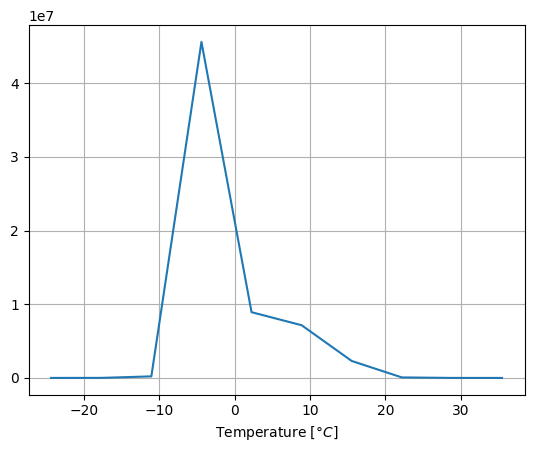

In [11]:
t_part.size
# Crea un histograma
r_tp = np.histogram(t_part)

# Obtén los valores del histograma
va_tp = r_tp[0]

# Visualiza el histograma
plt.plot(r_tp[1][:-1], va_tp)
plt.xlabel('Temperature [$\degree C$]')
plt.grid()
plt.show()

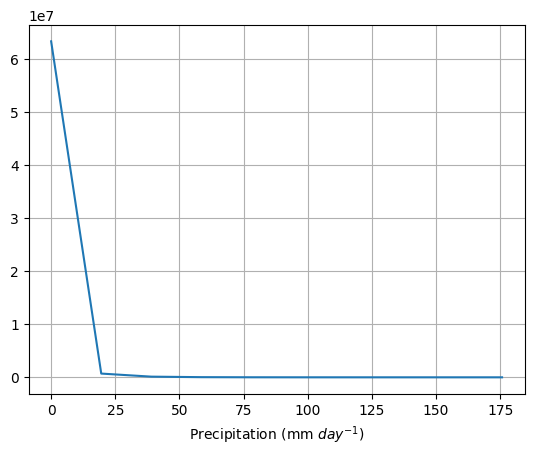

In [12]:
p_part.size
# Crea un histograma
r_pp = np.histogram(p_part)

# Obtén los valores del histograma
va_pp = r_pp[0]

# Visualiza el histograma
plt.plot(r_pp[1][:-1], va_pp)
plt.xlabel('Precipitation (mm $day^{-1}$)')
plt.grid()
plt.show()

In [13]:
KSF = K_sf1(t_part)

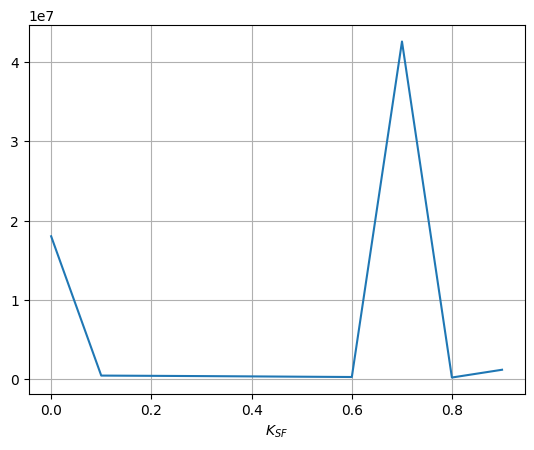

[0.000e+00 4.168e-04 8.335e-04 ... 9.990e-01 9.995e-01 1.000e+00]


In [14]:
# Crea un histograma
r_ksf = np.histogram(KSF)

# Obtén los valores del histograma
va_ksf = r_ksf[0]

# Visualiza el histograma
plt.plot(r_ksf[1][:-1], va_ksf)
plt.xlabel('$K_{SF}$')
plt.grid()
plt.show()

print(np.unique(KSF))

In [15]:
snowfall = S(p_part, KSF)
np.unique(snowfall)

array([0.0000000e+00, 2.9175950e-05, 3.7506485e-05, ..., 1.2634000e+02,
       1.2762001e+02, 1.4393001e+02], dtype=float32)

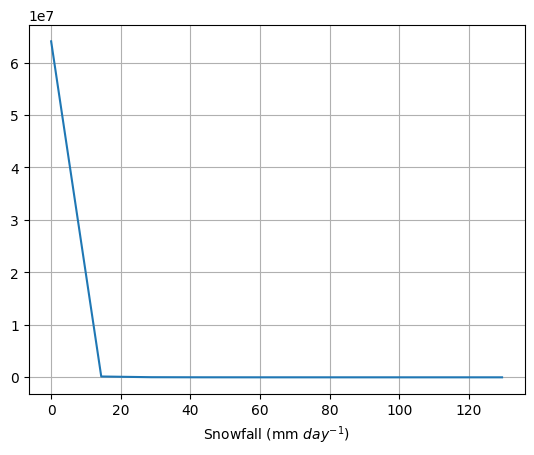

In [16]:
# Crea un histograma
r_S = np.histogram(snowfall)

# Obtén los valores del histograma
va_S = r_S[0]

# Visualiza el histograma
plt.plot(r_S[1][:-1], va_S)
plt.xlabel('Snowfall (mm $day^{-1}$)')
plt.grid()
plt.show()

C:\Users\Josemanuel\AppData\Local\Temp\ipykernel_17868\4082100013.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(t_part, snowfall/p_part)


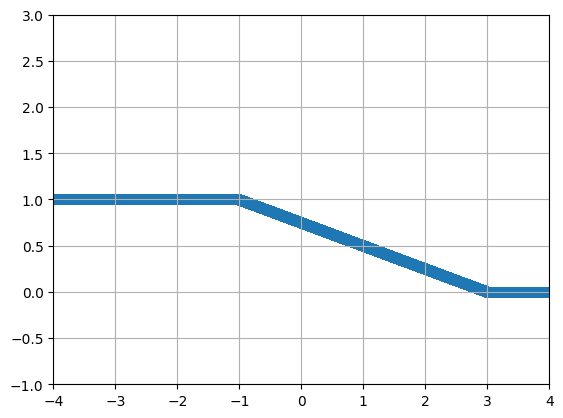

In [17]:
plt.scatter(t_part, snowfall/p_part)
plt.xlim(-4,4)
plt.ylim(-1,3)
plt.grid()

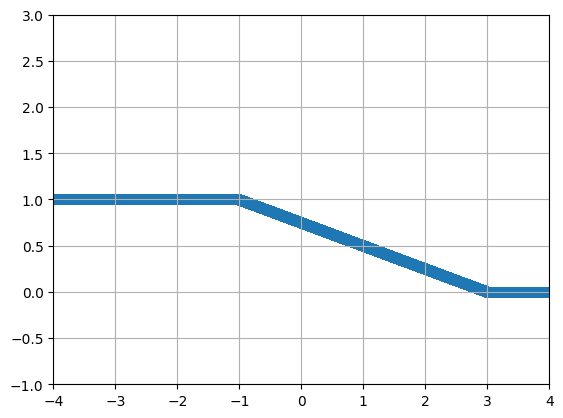

In [19]:
valid_indices = (p_part != 0)

# Filtra los datos para excluir aquellos donde p_part es cero
t_part_valid = t_part[valid_indices]
snowfall_valid = snowfall[valid_indices]
p_part_valid = p_part[valid_indices]

# Ahora puedes realizar la gráfica sin preocuparte por la división por cero
plt.scatter(t_part_valid, snowfall_valid / p_part_valid)
plt.xlim(-4,4)
plt.ylim(-1,3)
plt.grid()
plt.show()

---------------------------------------------------

## Modelo II

Queremos encontrar: 

$A = min(A^{*}, A_{max}, \frac{SWE}{\Delta t} + S)$

Donde $A^{*}$:

$ A^{*} =
\begin{cases}
    0, & \text{if } T \leq T_{A} \\
    \frac{A_{0}(T_{A} - T)}{T_{A}}, & \text{if } T_{A} \leq T \leq 0 \\
    aT^{2} + bT + A_{0} , & \text{if } 0 < T
\end{cases}$



### Aplicando A para calcular ablation en todas las series de tiempo

In [67]:
t_part = parti(0,365, T=True)
p_part = parti(0,365, P=True)

In [68]:
A_ = A_asterisco(t_part)

In [85]:
Ablation = A(t_part)

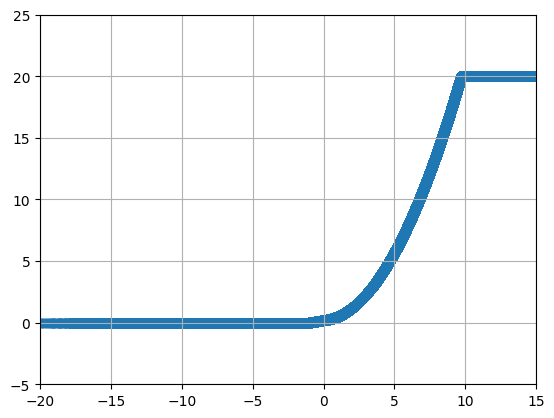

In [86]:
plt.scatter(t_part, Ablation)
plt.ylim(-5,25)
plt.xlim(-20,15)
plt.grid()

##  Modelo Completo

### Aplicando SWE

In [9]:
#15737 cantidad total de dias

t_part1 = parti(0,15737, T=True)
p_part1 = parti(0,15737, P=True)

swe, snow_f, abla = modelo_completo4(t_part1, p_part1)

NameError: name 'ds_t2m' is not defined

### Testing

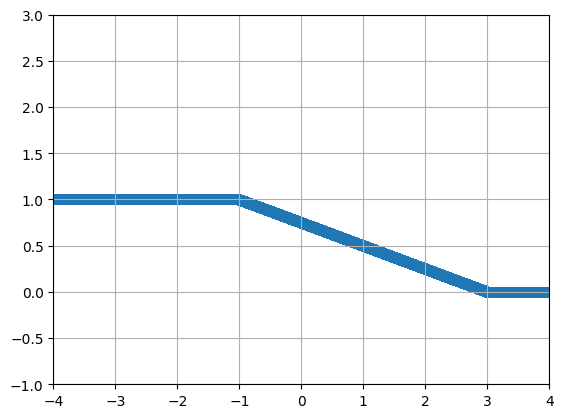

In [342]:
valid_indices = (p_part1 != 0)

# Filtra los datos para excluir aquellos donde p_part es cero
t_part_valid = t_part1[valid_indices]
snowfall_valid = snow_f[valid_indices]
p_part_valid = p_part1[valid_indices]

# Ahora puedes realizar la gráfica sin preocuparte por la división por cero
plt.scatter(t_part_valid, snowfall_valid / p_part_valid)
plt.xlim(-4,4)
plt.ylim(-1,3)
plt.grid()
plt.show()

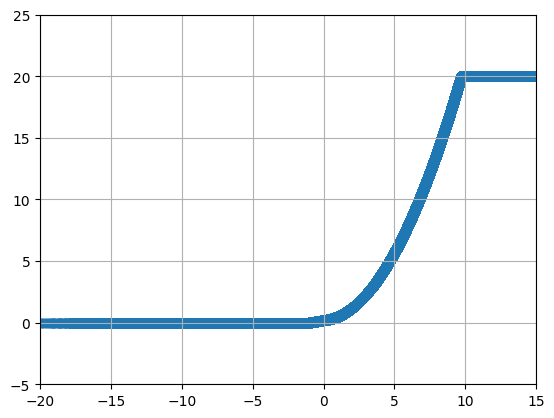

In [285]:
plt.scatter(t_part1, abla)
plt.ylim(-5,25)
plt.xlim(-20,15)
plt.grid()

In [344]:
swe[:1,:,:].plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [321]:
abla[:,:,:]

array([[[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        ...,
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]],

       [[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        ...,
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]],

       [[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        ...,
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]],

       ...,

       [[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2

In [307]:
snow_f[2,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

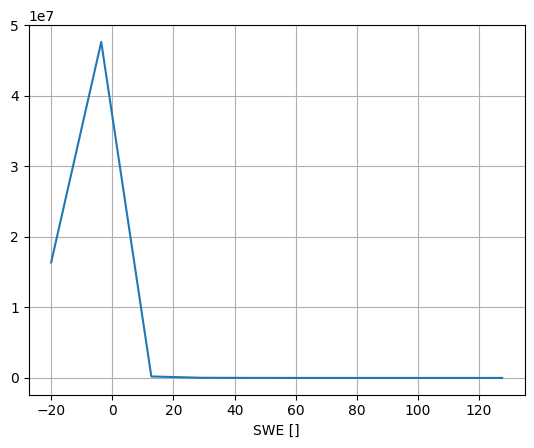

In [329]:
# Crea un histograma
h_swe = np.histogram(swe)

# Obtén los valores del histograma
values_swe = h_swe[0]

# Visualiza el histograma
plt.plot(h_swe[1][:-1], values_swe)
plt.xlabel('SWE []')
plt.grid()
plt.show()

### Aplicando modelo completo final

#### Testing

In [52]:
t_part2 = parti(0,15737, T=True)
p_part2 = parti(0,15737, P=True)

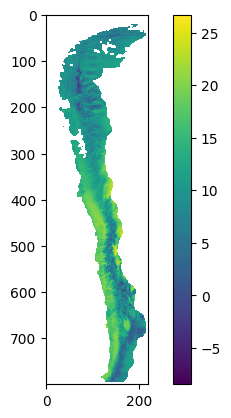

In [53]:
#plt.imshow(t_part2[0,:,:]-p_part2[0,:,:])
plt.imshow(t_part2[0,:,:])
plt.colorbar()

In [50]:
t_part2[0,700,0]

0.0

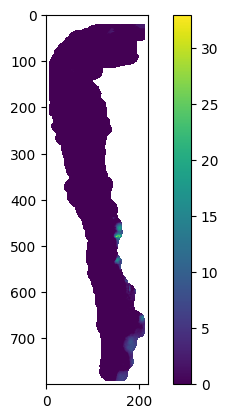

In [54]:
plt.imshow(p_part2[0,:,:])
plt.colorbar()

In [42]:
p_part2.shape

(15096, 800, 220)

#### Aplication

In [7]:
t_part2 = parti(0,15737, T=True)
p_part2 = parti(0,15737, P=True)

swe_c, snow_f_c, abla_c = modelo_completo_final(t_part2, p_part2, t_s, t_r, t_a, A_0, a, b, A_max)

In [8]:
swe_c = swe_c.astype('float32')
snow_f_c = snow_f_c.astype('float32')
abla_c = abla_c.astype('float32')
ds_swe = xr.Dataset(
    {
        'swe': (['time', 'lat', 'lon'], swe_c, {'units': 'mm/day'}),
        'snow_f': (['time', 'lat', 'lon'], snow_f_c, {'units': 'mm/day'}),
        'abla': (['time', 'lat', 'lon'], abla_c, {'units': 'mm/day'})
    },
    coords={
        'time': ds_pr['time'],
        'lat': ds_pr['lat'],
        'lon': ds_pr['lon']
    }
)

# Agrega atributos adicionales si es necesario
#ds_swe.attrs['units'] = 'mm'  # Ajusta las unidades según sea necesario

# Guarda el conjunto de datos en un archivo NetCDF
ds_swe.to_netcdf('SWE_day_1979_2020.nc')

## SWE

In [4]:
ds_SWE = xr.open_dataset('SWE_day_1979_2020.nc')

In [5]:
ds_SWE

<xarray.Dataset>
Dimensions:  (time: 15096, lat: 800, lon: 220)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-04-30
  * lat      (lat) float32 -56.97 -56.92 -56.88 -56.83 ... -17.12 -17.08 -17.02
  * lon      (lon) float32 -76.97 -76.93 -76.88 -76.82 ... -66.12 -66.07 -66.03
Data variables:
    swe      (time, lat, lon) float32 ...
    snow_f   (time, lat, lon) float32 ...
    abla     (time, lat, lon) float32 ...

In [6]:
ds_t2m

<xarray.Dataset>
Dimensions:  (lat: 800, lon: 220, time: 15096)
Coordinates:
  * lat      (lat) float32 -56.97 -56.92 -56.88 -56.83 ... -17.12 -17.08 -17.02
  * lon      (lon) float32 -76.97 -76.93 -76.88 -76.82 ... -66.12 -66.07 -66.03
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-04-30
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes: (12/20)
    creation_date:       21-Sep-2020 19:15:10
    ls_vars_s2:          tmin tmina tmax tmaxa t2m t2ma t850 t850a t700 td2m ...
    nb_months:           -1  0  1
    av_ens_qtl:          0.0
    agg_metr:            median
    authors:             Boisier et al.
    ...                  ...
    par_nd_stn_min:      10
    par_nd_stn_spl:      50
    par_dlat_min:        2
    par_dlat_max:        15
    history:             Wed Jan 22 12:11:25 2020: ncks -v tmin /home/nvaldeb...
    NCO:                 netCDF Operators version 4.7.9 (Homepage = httpwrite...

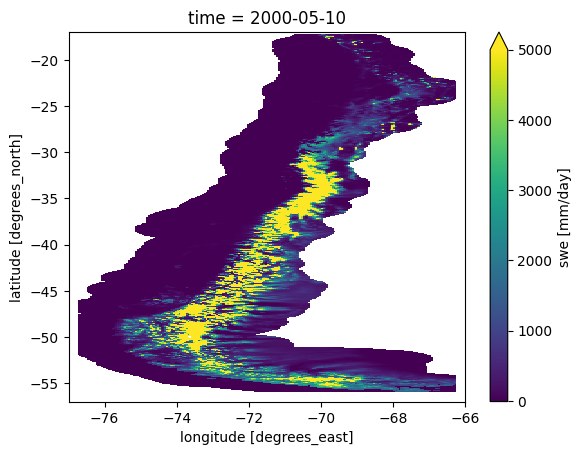

In [6]:
ds_SWE['swe'][7800,:,:].plot(vmin=-10,vmax=5000) #vmin=-10,vmax=5000

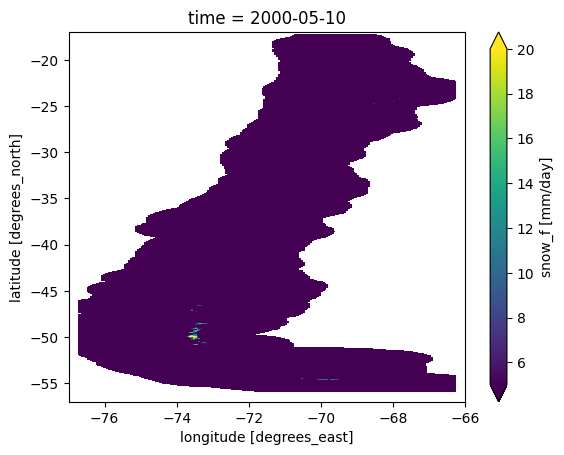

In [10]:
ds_SWE['snow_f'][7800,:,:].plot(vmin=5,vmax=20) #vmin=-10,vmax=5000

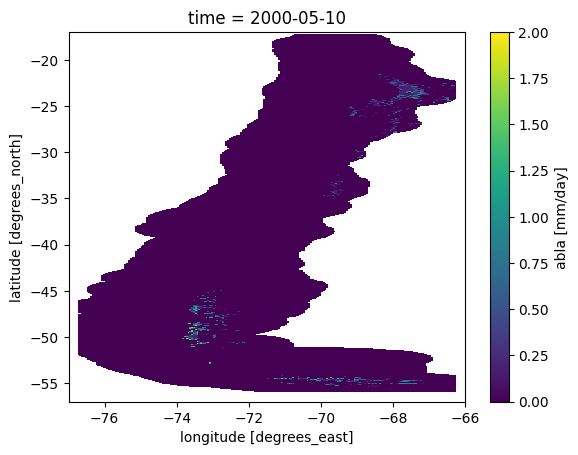

In [23]:
ds_SWE['abla'][7800,:,:].plot(vmin=0.0,vmax=2.0) #vmin=-10,vmax=5000

In [12]:
np.unique(ds_SWE['abla'][7800,:,:])

array([0.0000000e+00, 1.2083054e-03, 1.3847351e-03, ..., 1.8769531e+00,
       1.8847656e+00,           nan], dtype=float32)

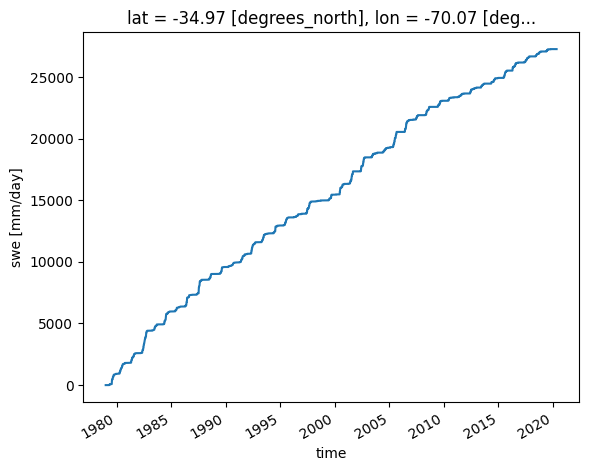

In [15]:
pt  = ds_SWE.sel(lat=-35., lon=-70.1, method='nearest')
pt['swe'].plot()

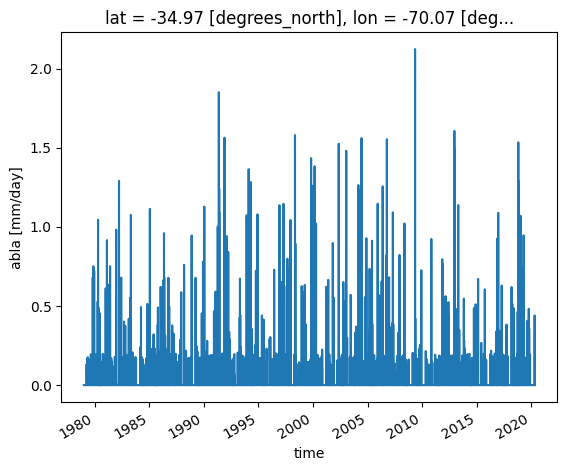

In [16]:
pt['abla'].plot()

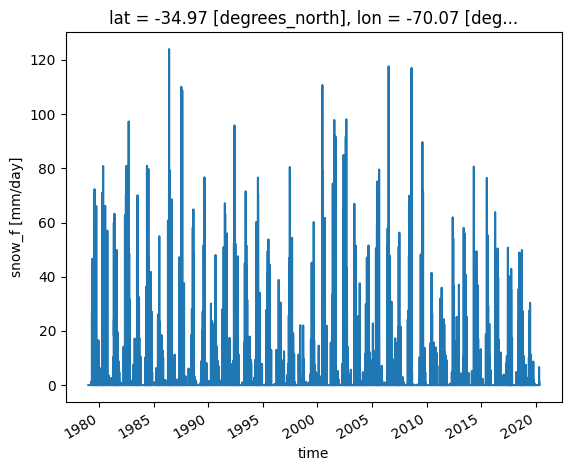

In [24]:
pt['snow_f'].plot()

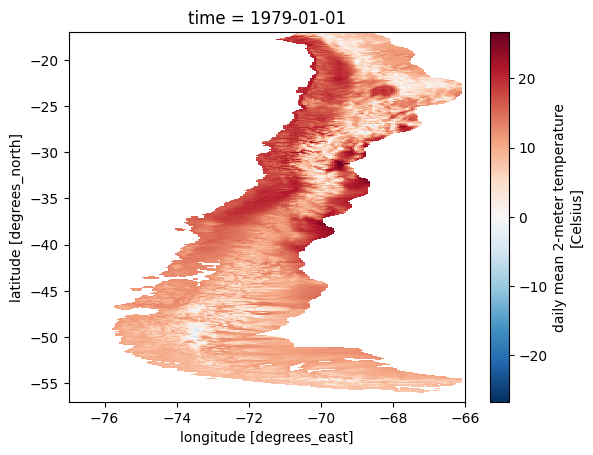

In [37]:
ds_t2m['t2m'][:1,:,:].plot()

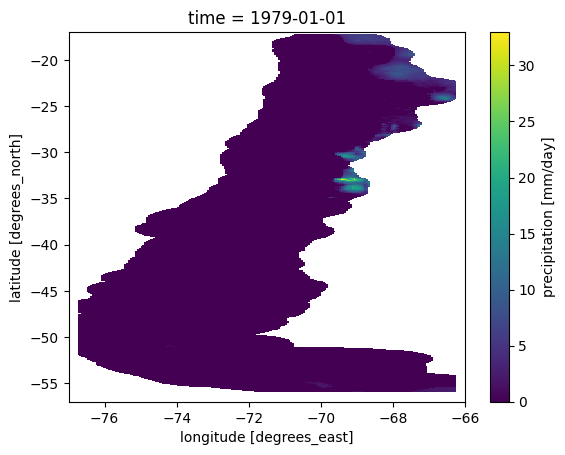

In [38]:
ds_pr['pr'][:1,:,:].plot()